In [1]:
# Install Prophet and Plotly if not already available
!pip install prophet plotly



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from prophet import Prophet
from sklearn.metrics import r2_score

plt.style.use("ggplot")


In [5]:
from google.colab import files

uploaded = files.upload()



Saving CONVENIENT_global_confirmed_cases.csv to CONVENIENT_global_confirmed_cases.csv


In [6]:
from google.colab import files

uploaded = files.upload()


Saving CONVENIENT_global_deaths.csv to CONVENIENT_global_deaths.csv


In [7]:
from google.colab import files

uploaded = files.upload()


Saving continents2.csv to continents2.csv


In [8]:
df0 = pd.read_csv("CONVENIENT_global_confirmed_cases.csv")
df1 = pd.read_csv("CONVENIENT_global_deaths.csv")
continent = pd.read_csv("continents2.csv")

continent["name"] = continent["name"].str.upper()


In [9]:
world = pd.DataFrame({"Country": df0.columns[1:]})
cases = [pd.to_numeric(df0[country][1:]).sum() for country in world["Country"]]
world["Cases"] = cases

# Clean country names
country_list = list(world["Country"].values)
for idx, i in enumerate(country_list):
    if '.' in i:
        i = i.split('.')[0]
    if '(' in i:
        i = i.split('(')[0].strip()
    country_list[idx] = i
world["Country"] = country_list

# Group similar countries
world = world.groupby("Country")["Cases"].sum().reset_index()


In [10]:
world["Cases Range"] = pd.cut(world["Cases"],
                              [-150000, 50000, 200000, 800000, 1500000, 15000000],
                              labels=["U50K", "50Kto200K", "200Kto800K", "800Kto1.5M", "1.5M+"] )

alpha = []
for name in world["Country"].str.upper():
    if name == "BRUNEI":
        name = "BRUNEI DARUSSALAM"
    elif name == "US":
        name = "UNITED STATES"
    code = continent[continent["name"] == name]["alpha-3"].values
    alpha.append(code[0] if len(code) > 0 else np.nan)
world["Alpha3"] = alpha


In [11]:
fig = px.choropleth(world.dropna(),
                    locations="Alpha3",
                    color="Cases Range",
                    projection="mercator",
                    color_discrete_sequence=["white", "khaki", "yellow", "orange", "red"])
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


/tmp/ipython-input-12-580594940.py:9: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



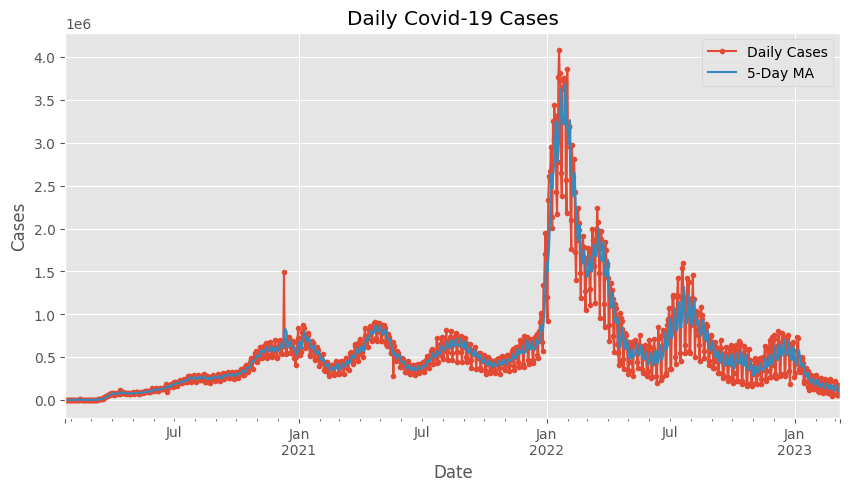

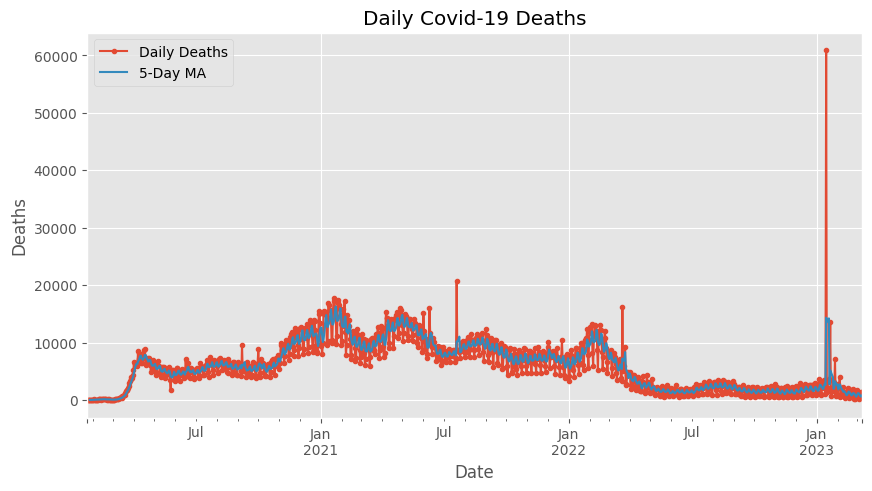

In [12]:
# Daily cases
case_counts = [pd.to_numeric(df0.iloc[i, 1:]).sum() for i in range(1, len(df0))]
death_counts = [pd.to_numeric(df1.iloc[i, 1:]).sum() for i in range(1, len(df1))]

df = pd.DataFrame()
df["Date"] = df0["Country/Region"][1:]
df["Cases"] = case_counts
df["Deaths"] = death_counts
df = df.set_index(pd.to_datetime(df["Date"]))

# Plot daily cases
df["Cases"].plot(title="Daily Covid-19 Cases", marker=".", figsize=(10,5), label="Daily Cases")
df["Cases"].rolling(window=5).mean().plot(label="5-Day MA")
plt.ylabel("Cases")
plt.legend()
plt.show()

# Plot daily deaths
df["Deaths"].plot(title="Daily Covid-19 Deaths", marker=".", figsize=(10,5), label="Daily Deaths")
df["Deaths"].rolling(window=5).mean().plot(label="5-Day MA")
plt.ylabel("Deaths")
plt.legend()
plt.show()


In [13]:
class Fbprophet:
    def fit(self, data):
        self.data = data
        self.model = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=False)
        self.model.fit(self.data)

    def forecast(self, periods, freq):
        self.future = self.model.make_future_dataframe(periods=periods, freq=freq)
        self.df_forecast = self.model.predict(self.future)

    def plot(self, xlabel="Date", ylabel="Cases"):
        self.model.plot(self.df_forecast)
        self.model.plot_components(self.df_forecast)

    def R2(self):
        return r2_score(self.data['y'], self.df_forecast['yhat'][:len(self.data)])


In [14]:
df_fb = pd.DataFrame({
    "ds": df.index,
    "y": df["Cases"].values
})

model = Fbprophet()
model.fit(df_fb)
model.forecast(30, "D")
print("R² Score:", model.R2())


DEBUG:cmdstanpy:input tempfile: /tmp/tmpr56i64v_/kbchbj_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr56i64v_/op72ijwj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93278', 'data', 'file=/tmp/tmpr56i64v_/kbchbj_a.json', 'init=/tmp/tmpr56i64v_/op72ijwj.json', 'output', 'file=/tmp/tmpr56i64v_/prophet_model87vks3v4/prophet_model-20250727182401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:24:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:24:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


R² Score: 0.6850267872612941


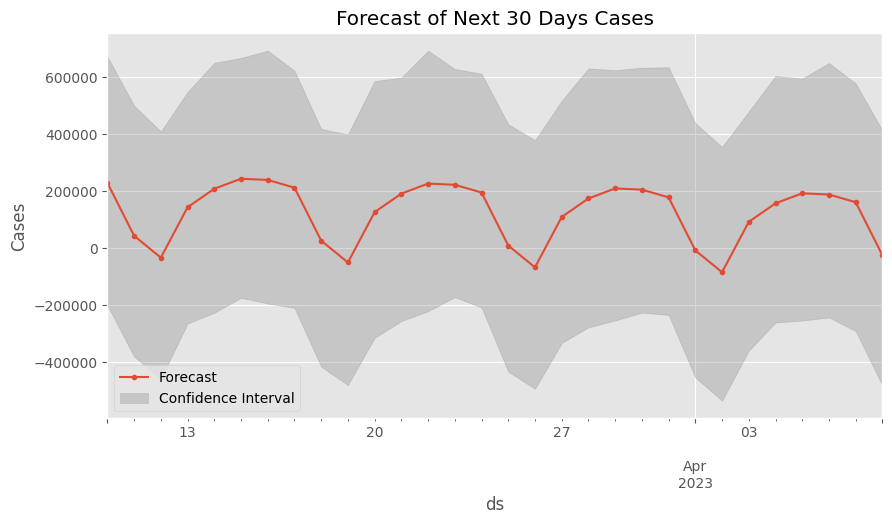

In [15]:
forecast = model.df_forecast[["ds", "yhat_lower", "yhat_upper", "yhat"]].tail(30).reset_index(drop=True)
forecast.set_index("ds", inplace=True)

forecast["yhat"].plot(marker=".", figsize=(10, 5))
plt.fill_between(forecast.index, forecast["yhat_lower"], forecast["yhat_upper"], color="gray", alpha=0.3)
plt.title("Forecast of Next 30 Days Cases")
plt.legend(["Forecast", "Confidence Interval"])
plt.ylabel("Cases")
plt.show()
